<a href="https://colab.research.google.com/github/alessioborgi/DL_Project/blob/main/Source/InfoRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

==================================================

**Project Name:** Neural inverted index for fast and effective information retrieval\
**Course:** Deep Learning\
**University:** Sapienza Università di Roma

**Authors:**
  - [Alessio Borgi] (<tt>1952442</tt>)
  - [Eugenio Bugli] (<tt>1934824</tt>)
  - [Damiano Imola] (<tt>2109063</tt>)

**Date:** [November 2024 - Completion Date]


**Implementations**
*   Differentiable Search Index architecture
*   DSI-Multi dataset generation


**Novelties**
*   Dynamic pruning
*   Semantic and Stopwords Augmentation




==================================================

# 0: INSTALL & IMPORT LIBRARIES

In [1]:
%%capture
!pip install -q --upgrade pip
# it takes quite a lot
!pip install -q pyserini==0.12.0
# !pip install -q pyserini==0.21.0
# !pip install -q faiss-gpu
!pip install -q pytorch-lightning transformers datasets torch wandb

!git clone https://github.com/alessioborgi/DL_Project.git

In [2]:
# base
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from typing import List, Tuple
from tqdm import tqdm

# for pyserini stuffs
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# cool plots
import wandb

# torch
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, StochasticWeightAveraging, DeviceStatsMonitor, ModelPruning


# HF and similar
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer, AutoTokenizer, AutoModelForSequenceClassification, T5Tokenizer, T5ForConditionalGeneration, EncoderDecoderCache

# sklearn
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering, KMeans

# pyserini
# import faiss
from pyserini.index import IndexReader
from pyserini.search import SimpleSearcher
# from pyserini.search.lucene import LuceneSearcher

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, RegexpTokenizer


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Currently using {device}")

Currently using cuda


In [ ]:
wandb.login()
# wandb.login(key="b3bce19a09c51bdf8a19eb3dc58f7c44de929e13") #(ALESSIO)
# wandb.login(key="6d550e12a1b8f716ebe580082f495c01ed2adf6c") #(DAMIANO)
wandb.login(key="551e67be2c716a42ea3230a7c4fc639fc985f98f") #(EUGENIO)
wandb.init(project="IR_DSI", resume="allow")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: eugeniobugli15 (adavit). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1: LOAD TOKENIZED DATASET

In [ ]:
max_decoder_squence_len = 4 # manually computed
max_decoder_squence_len_1000 = max_decoder_squence_len * 1000 # supposed

In [ ]:
class DatasetLoader(torch.utils.data.Dataset):
    def __init__(self, file_name):
        self.data = torch.load(file_name)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
train_dataset = DatasetLoader('/content/drive/MyDrive/deep-learning-files/train_data_tokenized.pt')
val_dataset = DatasetLoader('/content/drive/MyDrive/deep-learning-files/validation_data_tokenized.pt')
test_dataset = DatasetLoader('/content/drive/MyDrive/deep-learning-files/test_data_tokenized.pt')

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

<ipython-input-5-5028a3bd384a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(file_name)


In [ ]:
print(len(train_dataset), len(val_dataset), len(test_dataset))
print(len(train_dataset) + len(val_dataset) + len(test_dataset))

6 6 6
18


# 2: MODEL

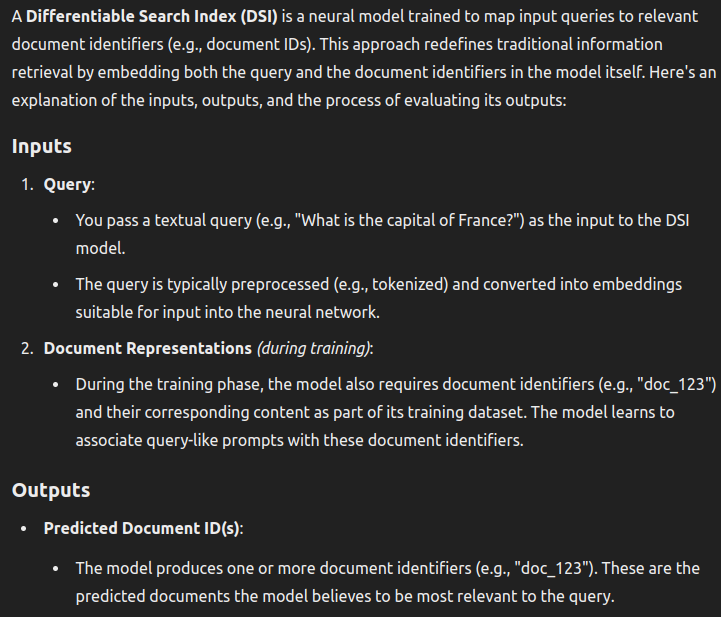

In [30]:
class DSIT5Model(pl.LightningModule):
    def __init__(self, model_name="t5-small", learning_rate=5e-5, max_decoder_squence_len=max_decoder_squence_len, max_decoder_squence_len_1000=max_decoder_squence_len_1000):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(model_name) # transformer
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.learning_rate = learning_rate



    def training_step(self, batch, batch_idx):
        queries = torch.Tensor(batch['query']).squeeze(1).to(device)
        input_ids = torch.Tensor(batch['input_ids']).squeeze(1)
        decoder_input_ids = torch.Tensor(batch['decoder_input_ids']).squeeze(1)
        decoder_1000_input_ids = torch.Tensor(batch['decoder_ranked_input_ids']).squeeze(1)

        # indexing task
        index_output = self.model(input_ids=input_ids, labels=decoder_input_ids)
        index_loss = index_output.loss

        # retrieval task
        retrieval_output = self.model(input_ids=input_ids, labels=queries)
        retrieval_loss = retrieval_output.loss

        loss = index_loss + retrieval_loss

        metrics = self.compute_metrics(input_ids, decoder_input_ids, decoder_1000_input_ids)

        self.log("train_loss", loss, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx):
        queries = torch.Tensor(batch['query']).squeeze(1).to(device)
        input_ids = torch.Tensor(batch['input_ids']).squeeze(1)
        decoder_input_ids = torch.Tensor(batch['decoder_input_ids']).squeeze(1)
        decoder_1000_input_ids = torch.Tensor(batch['decoder_ranked_input_ids']).squeeze(1)

        # indexing task
        index_output = self.model(input_ids=input_ids, labels=decoder_input_ids)
        index_loss = index_output.loss

        # retrieval task
        retrieval_output = self.model(input_ids=input_ids, labels=queries)
        retrieval_loss = retrieval_output.loss

        loss = index_loss + retrieval_loss

        metrics = self.compute_metrics(input_ids, decoder_input_ids, decoder_1000_input_ids)

        self.log("validation_loss", loss, on_epoch=True)
        return loss



    def test_step(self, batch, batch_idx):
        queries = torch.Tensor(batch['query']).squeeze(1).to(device)
        input_ids = torch.Tensor(batch['input_ids']).squeeze(1)
        decoder_input_ids = torch.Tensor(batch['decoder_input_ids']).squeeze(1)
        decoder_1000_input_ids = torch.Tensor(batch['decoder_ranked_input_ids']).squeeze(1)

        # indexing task
        index_output = self.model(input_ids=input_ids, labels=decoder_input_ids)
        index_loss = index_output.loss

        # retrieval task
        retrieval_output = self.model(input_ids=input_ids, labels=queries)
        retrieval_loss = retrieval_output.loss

        loss = index_loss + retrieval_loss

        metrics = self.compute_metrics(queries, decoder_input_ids, decoder_1000_input_ids)

        self.log("test_loss", loss, on_epoch=True)
        return loss




    def compute_metrics(self, input_ids, decoder_input_ids, decoder_1000_input_ids):
        # infer top 1000 documents
        predicted_docids_tokenized = self.model.generate(input_ids, max_length=max_decoder_squence_len_1000)

        predicted_docids = []
        predicted_1000_docids = []
        for prediction in predicted_docids_tokenized:
            # retrieve top 1
            decoded = self.tokenizer.decode(prediction[:max_decoder_squence_len], skip_special_tokens=True)
            predicted_docids.append(decoded.split()[0])

            # retrieve top 1000
            decoded_1000 = self.tokenizer.decode(prediction[:max_decoder_squence_len_1000], skip_special_tokens=True)
            predicted_1000_docids.append(decoded_1000.split())


        # ground truth
        target_docids = []
        for ground_truth in decoder_input_ids:
            decoded = self.tokenizer.decode(ground_truth, skip_special_tokens=True)
            target_docids.append(decoded)


        # compute metrics
        recall_at_1000 = self.compute_recall_at_1000(predicted_1000_docids, decoder_1000_input_ids)
        map = self.compute_map(predicted_docids, target_docids)

        return {
            "recall_at_1000": recall_at_1000,
            "map": map
        }




    def compute_recall_at_1000(self, predicted_docids, target_docids):
        recalls = []

        for predicted, target in zip(predicted_docids, target_docids):
            predicted_set = set(predicted[:1000])
            target_set = set(target)

            if not target_set:
                recalls.append(0)
                continue

            recall = len(predicted_set.intersection(target_set)) / len(target_set)
            recalls.append(recall)

        return np.mean(recalls)



    def compute_map(self, predicted_docids, target_docids):
        aps = []
        for predicted, target in zip(predicted_docids, target_docids):
            target_set = set(target.split())

            if not target_set:
                aps.append(0)
                continue

            precision_at_k = []
            num_hits = 0

            for i, doc in enumerate(predicted_docids):
                if doc in target_set:
                    num_hits += 1
                    precision_at_k.append(num_hits / (i + 1))

            # Average Precision for this query
            aps.append(np.mean(precision_at_k) if precision_at_k else 0)

        return np.mean(aps)


    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

# 3: TRAINING

In [ ]:
model = DSIT5Model()

logger = WandbLogger(project="IR_DSI_Project")

# ===== CALLBACKS =====
checkpoint_callback = ModelCheckpoint(
    monitor='validation_loss',
    dirpath='checkpoints/',
    filename='dsi-t5-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min'
)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')

# ===== DYNAMIC PRUNING ====
# removes individual weights based on magnitude or importance
# removes the ones with smallest L1 norm
# amount removes 20% of the smallest magnitude weights
pruning_callback = ModelPruning("l1_unstructured", amount=0.5)

trainer = pl.Trainer(
    max_epochs=5,
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback, pruning_callback],

    accelerator="auto",

    # gradient accumulation
    accumulate_grad_batches=4, # gradient is computed after 4 batches

    # mixed precision
    precision='16-mixed', # 16 bit precision of my model
)

# Train the model
trainer.fit(model, train_dataloader, val_dataloaders=val_dataloader)

wandb.finish()

In [35]:
# dump everything in your GPU (call 3 times to work)
import gc
gc.collect()
# del model, trainer
torch.cuda.empty_cache()

# 8: FURTHER IMPROVEMENTS AND TODOS

In [ ]:
# TODO
# 1. refactoring totale (EUGENIO)
# 2. mean number of words in passages with and without stopwords/punktuation (plot)
# 3. (DAMIANO) Adversarial Natural Language Inference
# 4. Generate Dataset of top1000 results by using a ranker (Faiss)

In [ ]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

# ---------------------------
# 1. Dataset Preparation
# ---------------------------
class MSMarcoDataset(Dataset):
    def _init_(self, queries, documents, docids, tokenizer, max_length=512):
        """
        :param queries: List of query texts
        :param documents: List of document texts
        :param docids: List of document IDs (targets)
        :param tokenizer: Pretrained tokenizer (e.g., T5 tokenizer)
        :param max_length: Max token length for inputs/outputs
        """
        self.queries = queries
        self.documents = documents
        self.docids = docids
        self.tokenizer = tokenizer
        self.max_length = max_length

    def _len_(self):
        return len(self.queries)

    def _getitem_(self, idx):
        query = self.queries[idx]
        document = self.documents[idx]
        docid = self.docids[idx]

        input_text = f"Document: {document} Query: {query}"
        target_text = f"DocID: {docid}"

        input_enc = self.tokenizer(
            input_text, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        target_enc = self.tokenizer(
            target_text, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt"
        )

        return {
            "input_ids": input_enc["input_ids"].squeeze(0),
            "attention_mask": input_enc["attention_mask"].squeeze(0),
            "labels": target_enc["input_ids"].squeeze(0),
        }

# ---------------------------
# 2. Lightning Module
# ---------------------------
class DSIModule(pl.LightningModule):
    def _init_(self, model_name="t5-small", lr=3e-5):
        super()._init_()
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.lr = lr

    def forward(self, input_ids, attention_mask, labels):
        return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], labels=batch["labels"])
        loss = outputs.loss
        self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=self.lr)

# ---------------------------
# 3. Data Preparation
# ---------------------------
def prepare_data(tokenizer, max_length=512):
    # Placeholder for loading MS MARCO data
    queries = ["What is the capital of France?", "Who wrote Hamlet?"]
    documents = ["Paris is the capital of France.", "Shakespeare wrote Hamlet."]
    docids = ["doc123", "doc456"]

    dataset = MSMarcoDataset(queries, documents, docids, tokenizer, max_length)
    return DataLoader(dataset, batch_size=8, shuffle=True)

# ---------------------------
# 4. Training
# ---------------------------
if _name_ == "_main_":
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    train_loader = prepare_data(tokenizer)
    val_loader = prepare_data(tokenizer)

    model = DSIModule(model_name="t5-small")

    trainer = pl.Trainer(max_epochs=5, accelerator="gpu", devices=1)
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)